## <b>AdaIN Style Transfer Tutorial</b>

* 원본 논문: [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization (ICCV 2017)](https://arxiv.org/abs/1703.06868)
* <b>Feed-Forward Network</b>를 이용하여 <b>임의의(arbitrary)</b> 스타일 이미지를 활용한 <b>스타일 전송(style transfer)</b>을 실시간으로 수행합니다.
    * 이미지에 대한 기울기(gradient)를 직접 구하지 않아도 되므로 <b>훨씬 빠르게</b> 스타일을 전송할 수 있습니다.
* 소스코드를 실행하기 전에 **[런타임]** - **[런타임 유형 변경]** - **[GPU]**로 설정되어 있는지 확인합니다.
* 본 코드는 논문에서 제시한 파라미터 및 설정을 온전히 따르고 있습니다.

#### <b>AdaIN Style Transfer 네트워크</b>

* 앞서 정의한 인코더와 디코더를 이용하는 하나의 네트워크를 정의합니다.
* 먼저 인코더(encoder)를 통해 feature map을 추출한 뒤에 AdaIN을 거쳐 Style Transfer를 수행합니다.
* 디코더는 처리된 feature를 입력받아 결과 이미지를 생성합니다.
* <b>본 실습에서 사용하지는 않지만</b> 아키텍처를 이해하기 위해 코드를 확인해 봅시다.

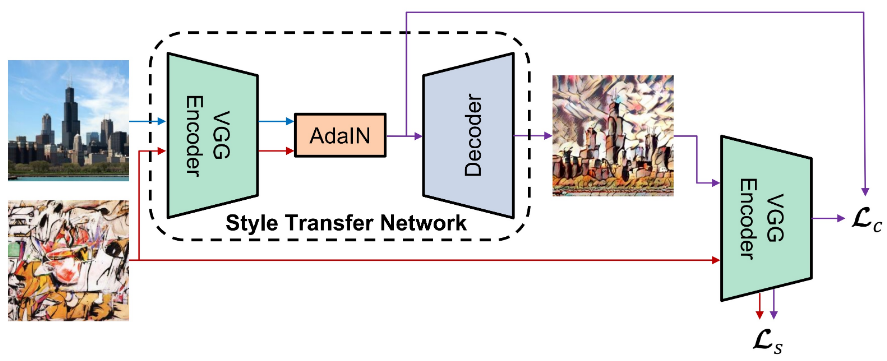

#### <b>실습에 필요한 라이브러리 불러오기 및 환경 설정</b>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

#### <b>인코더 및 디코더 네트워크</b>

* <b>인코더(Encoder)</b>: VGG 형식의 네트워크를 사용하여 이미지로부터 특징(feature)을 추출(extract)합니다.
* <b>디코더(Decoder)</b>: 인코더와 유사한 네트워크이지만 <b>반대로 해상도(너비 X 높이)를 키우는 방식으로 동작</b>합니다.

#### <b>인코더(Encoder)</b>

* VGG 네트워크에서 맥스 풀링(max pooling)을 총 4번 진행하지만, Style Transfer에서는 ReLU4_1까지만 사용합니다.
    * 따라서 사실상 다운샘플링(downsampling)은 3번까지만 진행된다고 이해할 수 있습니다.

In [3]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

#### <b>디코더(Decoder)</b>

* 디코더는 인코더 네트워크를 반대로 뒤집은 것과 유사한 구조를 가집니다.
* 인코더 파트에서 3번의 다운샘플링(downsampling)을 거치므로, 디코더에서는 3번의 업샘플링(upsampling)을 거칩니다.

In [4]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

#### <b>사전 학습된(Pre-trained) 모델 불러오기</b> 

In [10]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2021-08-16 09:45:11--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYnM2WEVTMzdvdExnV1c1Y2F2Q1k5WUJ5R09uWEpENXdDMFdaZ1FQcDh2QUpnP3J0aW1lPU1QSGJpcHBnMlVn [following]
--2021-08-16 09:45:12--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9

In [11]:
# get trained model
decoder.eval() # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

In [12]:
def calc_mean_std(feat, eps=1e-5):
    ''' 이미지의 각 채널 평균(mean)과 표준편차(std) 값을 계산 '''
    size = feat.size()
    assert (len(size) == 4) # Feature Map의 형태: (N: 배치 크기, C: 채널 크기, H: 높이, W: 너비)
    N, C = size[:2]  # 한 번에 하나의 이미지만 넣을 것이므로 N은 1
    feat_var = feat.view(N, C, -1).var(dim=2) + eps # 입실론(epsilon)은 0으로 나누는 것을 예방하기 위한 작은 상수
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

In [13]:
def adaptive_instance_normalization(content_feat, style_feat):
    ''' content image에 style 적용'''
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

In [14]:
def style_transfer(vgg, decoder, content, style, alpha=1.0): # main
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [15]:
def test_transform(size=512): # main
    ''' 이미지 전처리 '''
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform
content_tf = test_transform()
style_tf = test_transform()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


전체 소요 시간: 0.6


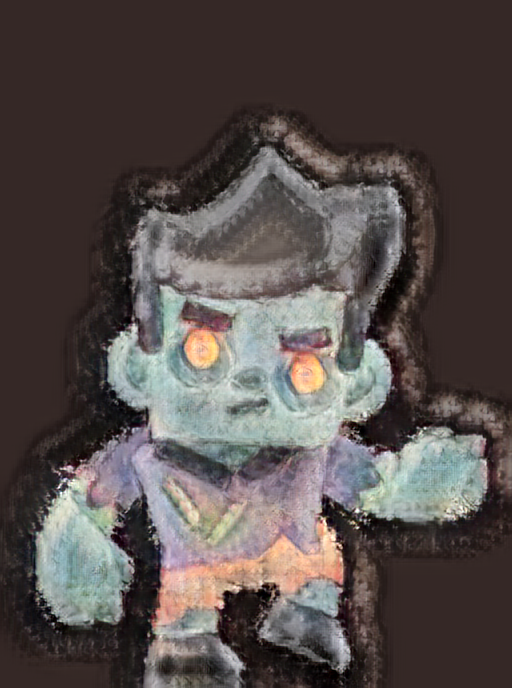

In [17]:
import time
start = time.time()

# 디렉터리 내 이미지 전체에 스타일 변이 코드 추가 필요

# main
content_path = '/content/drive/MyDrive/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/Zombie/character_zombie_attack0.png'
style_path = '/content/drive/MyDrive/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror37.jpg'

content_image = Image.open(str(content_path)).convert("RGB") # 배경 요소 제거
content = content_tf(content_image)
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)

with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0) # alpha 파라미터를 조절하여 콘텐츠 비율을 증가시킬 수 있습니다.
output = output.cpu()

# alpha channel 추가 코드  추가 필요

save_image(output, '/content/drive/MyDrive/Colab Notebooks/data/model_test/output.png')

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

# 결과 이미지 출력
display_image('/content/drive/MyDrive/Colab Notebooks/data/model_test/output.png')